In [ ]:
!pip install --pre deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import deepchem as dc
from deepchem.models.optimizers import Adam, ExponentialDecay
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tasks, datasets, transformers = dc.molnet.load_muv( splitter='random')
train_dataset, valid_dataset, test_dataset = datasets
train_smiles = train_dataset.ids
valid_smiles = valid_dataset.ids

tokens = set()
for s in train_smiles:
  tokens = tokens.union(set(c for c in s))
tokens = sorted(list(tokens))


max_length = max(len(s) for s in train_smiles)
batch_size = 300
batches_per_epoch = len(train_smiles)/batch_size
model = dc.models.SeqToSeq(tokens,
                           tokens,
                           max_length,
                           encoder_layers=2,
                           decoder_layers=2,
                           embedding_dimension=256,
                           model_dir='fingerprint',
                           batch_size=batch_size,
                           learning_rate=ExponentialDecay(0.001, 0.9, batches_per_epoch))

def generate_sequences(epochs):
  for i in range(epochs):
    for s in train_smiles:
      yield (s, s)





In [ ]:
model.fit_sequences(generate_sequences(5))

In [ ]:
predicted = model.predict_from_sequences(valid_smiles[:500])
count = 0
for s,p in zip(valid_smiles[:500], predicted):
  if ''.join(p) == s:
    count += 1
print('reproduced', count, 'of 500 validation SMILES strings')

reproduced 0 of 500 validation SMILES strings


In [ ]:
train_embeddings = model.predict_embeddings(train_smiles)
train_embeddings_dataset = dc.data.NumpyDataset(train_embeddings,
                                                train_dataset.y,
                                                train_dataset.w.astype(np.float32),
                                                train_dataset.ids)

valid_embeddings = model.predict_embeddings(valid_smiles)
valid_embeddings_dataset = dc.data.NumpyDataset(valid_embeddings,
                                                valid_dataset.y,
                                                valid_dataset.w.astype(np.float32),
                                                valid_dataset.ids)

In [ ]:
valid_dataset

<DiskDataset X.shape: (783,), y.shape: (783, 12), w.shape: (783, 12), ids: ['COc1nc(N)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@@H]1O'
 'CC(=O)SC[C@@H](C)C(=O)N1CCC[C@H]1C(=O)N[C@@H](Cc1ccccc1)C(=O)O'
 'CN(C)c1cccc(O)c1' ... 'CCN(CC#N)c1cccc(C)c1' 'COC(=O)C=C(C)CCC=C(C)C'
 'COc1ccc2c3c1O[C@H]1C(=O)CC[C@H]4[C@@H](C2)N(C)CC[C@]314.COc1ccc2c3c1O[C@H]1C(=O)CC[C@H]4[C@@H](C2)N(C)CC[C@]314'], task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>

In [ ]:
model = dc.models.GraphConvModel(len(tasks), mode='regression')
model.fit(train_dataset, nb_epoch = 16)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Reshape_14:0", shape=(451,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Reshape_13:0", shape=(451, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Reshape_17:0", shape=(1564,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Reshape_16:0", shape=(1564, 64), dtype=float32

0.20804263651371002

In [ ]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print("train: ", model.evaluate(train_dataset, [metric], transformers ))
print("test: ", model.evaluate(test_dataset, [metric], transformers ))


train:  {'roc_auc_score': 0.9144913063786692}
test:  {'roc_auc_score': 0.7446606445591955}


In [ ]:
model.predict(train_dataset)

NameError: ignored

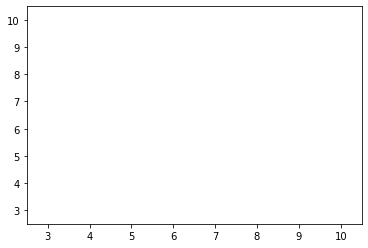

In [ ]:
y_meas_train = train_dataset.y
y_pred_train = (model.predict(train_dataset).T)

plt.xlim([2.5, 10.5])
plt.ylim([2.5, 10.5])
plt.scatter(y_meas_train, y_pred_train)

In [ ]:
(model.predict(train_dataset).T)

array([[ 0.0949219 ,  0.15774962, -0.1915411 , ..., -0.1687467 ,
         0.13923988,  0.01754925],
       [-0.3835174 ,  0.18287465, -0.14562857, ...,  0.69354004,
         0.42268726,  0.06456254],
       [ 0.29832426,  0.03639567,  0.32908916, ...,  0.12463187,
         0.43909422,  0.18831089],
       ...,
       [ 0.1278709 ,  0.498864  , -0.02631654, ...,  0.30229488,
         0.2784304 ,  0.00914572],
       [ 0.09339729,  0.15995064, -0.24911895, ...,  0.12400418,
         0.7327274 ,  0.15300909],
       [-0.05803835,  0.23869124, -0.34893724, ..., -0.26945093,
         0.4116303 ,  0.0759598 ]], dtype=float32)